# PPO TRAINING

This script trains PPO agents with various hyperparameter configurations
and tracks performance metrics for comparison with DQN.

In [11]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
import json
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("All imports successful!")
print(f"Working directory: {os.getcwd()}")

All imports successful!
Working directory: c:\Users\HP\Programming\ML\fire_rescue_agent\training


# PPO HYPERPARAMETER CONFIGURATIONS

Key PPO Hyperparameters:
- learning_rate: Step size for gradient updates
- gamma: Discount factor (same as DQN)
- batch_size: Number of experiences per update (different meaning than DQN)
- n_steps: Steps collected before update (PPO-specific)
- n_epochs: Number of passes through collected data (PPO-specific)
- clip_range: PPO clipping parameter (PPO-specific)
- gae_lambda: GAE parameter for advantage estimation (PPO-specific)
- ent_coef: Entropy coefficient for exploration (PPO-specific)
- vf_coef: Value function coefficient (PPO-specific)

Shared with DQN configs where possible:
- learning_rate, gamma, network architecture


In [12]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 2: IMPORT CUSTOM ENVIRONMENT
# ═══════════════════════════════════════════════════════════════════════
"""
Import Fire-Rescue environment
"""

import sys
import os

# Add parent directory to path to access sibling folders
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Import environment
from environment.custom_env import FireRescueEnv

print("✓ FireRescueEnv imported successfully")

✓ FireRescueEnv imported successfully


In [13]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 3: PPO HYPERPARAMETER CONFIGURATIONS
# ═══════════════════════════════════════════════════════════════════════
"""
Define all 11 PPO configurations
- Configs 2, 3, 6, 7 mirror DQN configs for direct comparison
- Configs 8, 9, 11 test PPO-specific parameters
- Config 10 is the optimized configuration

FIXED: Increased ent_coef from 0.01 to 0.05 to encourage exploration
       Agent was suffering from action space collapse (only using movement actions)
"""

PPO_CONFIGS = {
    # ─────────────────────────────────────────────────────────────────────
    # Config 1: BASELINE
    # ─────────────────────────────────────────────────────────────────────
    "config_1_baseline": {
        "learning_rate": 3e-4,
        "gamma": 0.99,
        "batch_size": 64,
        "n_steps": 2048,
        "n_epochs": 10,
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.05,  # INCREASED from 0.01 for better exploration
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Baseline - Standard PPO settings (FIXED exploration)"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 2: HIGH LEARNING RATE (Matches DQN config 2)
    # ─────────────────────────────────────────────────────────────────────
    "config_2_high_lr": {
        "learning_rate": 5e-3,
        "gamma": 0.99,
        "batch_size": 64,
        "n_steps": 2048,
        "n_epochs": 10,
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.05,  # INCREASED from 0.01
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "High LR - Compare with DQN config 2 (FIXED)"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 3: LOW LEARNING RATE (Matches DQN config 3)
    # ─────────────────────────────────────────────────────────────────────
    "config_3_low_lr": {
        "learning_rate": 1e-5,
        "gamma": 0.99,
        "batch_size": 64,
        "n_steps": 2048,
        "n_epochs": 10,
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.05,  # INCREASED from 0.01
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Low LR - Compare with DQN config 3 (FIXED)"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 4: LARGE BATCH
    # ─────────────────────────────────────────────────────────────────────
    "config_4_large_batch": {
        "learning_rate": 3e-4,
        "gamma": 0.99,
        "batch_size": 256,
        "n_steps": 2048,
        "n_epochs": 10,
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.05,
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Large Batch - Stable gradients"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 5: SMALL BATCH
    # ─────────────────────────────────────────────────────────────────────
    "config_5_small_batch": {
        "learning_rate": 3e-4,
        "gamma": 0.99,
        "batch_size": 32,
        "n_steps": 2048,
        "n_epochs": 10,
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.05,
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Small Batch - Fast updates"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 6: LOW GAMMA (Matches DQN config 6)
    # ─────────────────────────────────────────────────────────────────────
    "config_6_low_gamma": {
        "learning_rate": 3e-4,
        "gamma": 0.95,
        "batch_size": 64,
        "n_steps": 2048,
        "n_epochs": 10,
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.05,  # INCREASED from 0.01
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Low Gamma - Compare with DQN config 6 (FIXED)"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 7: HIGH GAMMA (Matches DQN config 7)
    # ─────────────────────────────────────────────────────────────────────
    "config_7_high_gamma": {
        "learning_rate": 3e-4,
        "gamma": 0.995,
        "batch_size": 64,
        "n_steps": 2048,
        "n_epochs": 10,
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.05,
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "High Gamma - Compare with DQN config 7"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 8: HIGH ENTROPY (PPO-specific)
    # ─────────────────────────────────────────────────────────────────────
    "config_8_high_entropy": {
        "learning_rate": 3e-4,
        "gamma": 0.99,
        "batch_size": 64,
        "n_steps": 2048,
        "n_epochs": 10,
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.1,  # High entropy
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "High Entropy - More exploration"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 9: LOW ENTROPY (PPO-specific)
    # ─────────────────────────────────────────────────────────────────────
    "config_9_low_entropy": {
        "learning_rate": 3e-4,
        "gamma": 0.99,
        "batch_size": 64,
        "n_steps": 2048,
        "n_epochs": 10,
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.0,  # No entropy
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Low Entropy - Pure exploitation"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 10: OPTIMIZED
    # ─────────────────────────────────────────────────────────────────────
    "config_10_optimized": {
        "learning_rate": 3e-4,
        "gamma": 0.99,
        "batch_size": 128,
        "n_steps": 4096,  # More steps
        "n_epochs": 15,  # More epochs
        "clip_range": 0.2,
        "gae_lambda": 0.98,
        "ent_coef": 0.05,
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[128, 128]),  # Deeper
        "description": "Optimized - Best guess for task"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 11: MANY EPOCHS (PPO-specific)
    # ─────────────────────────────────────────────────────────────────────
    "config_11_many_epochs": {
        "learning_rate": 3e-4,
        "gamma": 0.99,
        "batch_size": 64,
        "n_steps": 2048,
        "n_epochs": 20,  # Many epochs
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.05,
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Many Epochs - Sample efficient"
    },
}

# Print configuration summary
print(f"✓ Defined {len(PPO_CONFIGS)} PPO configurations\n")
print("="*110)
print(f"{'Config':<30} {'LR':<10} {'Gamma':<8} {'Batch':<8} {'N_Steps':<10} {'Epochs':<8} {'Ent_Coef':<12} {'Network':<12}")
print("="*110)

for config_name, config in PPO_CONFIGS.items():
    net_arch = str(config['policy_kwargs']['net_arch'])
    print(f"{config_name:<30} {config['learning_rate']:<10.0e} {config['gamma']:<8.3f} "
          f"{config['batch_size']:<8} {config['n_steps']:<10} "
          f"{config['n_epochs']:<8} {config['ent_coef']:<12.2f} {net_arch:<12}")

print("="*110)

✓ Defined 11 PPO configurations

Config                         LR         Gamma    Batch    N_Steps    Epochs   Ent_Coef     Network     
config_1_baseline              3e-04      0.990    64       2048       10       0.05         [64, 64]    
config_2_high_lr               5e-03      0.990    64       2048       10       0.05         [64, 64]    
config_3_low_lr                1e-05      0.990    64       2048       10       0.05         [64, 64]    
config_4_large_batch           3e-04      0.990    256      2048       10       0.05         [64, 64]    
config_5_small_batch           3e-04      0.990    32       2048       10       0.05         [64, 64]    
config_6_low_gamma             3e-04      0.950    64       2048       10       0.05         [64, 64]    
config_7_high_gamma            3e-04      0.995    64       2048       10       0.05         [64, 64]    
config_8_high_entropy          3e-04      0.990    64       2048       10       0.10         [64, 64]    
config_9_low_

In [14]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 4: CUSTOM CALLBACK FOR METRICS TRACKING
# ═══════════════════════════════════════════════════════════════════════
"""
Custom callback to track training metrics in real-time
"""

class MetricsCallback(BaseCallback):
    """
    Tracks episode rewards, lengths, and performs periodic evaluation
    """
    def __init__(self, eval_env, eval_freq=5000, verbose=1):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.episode_rewards = []
        self.episode_lengths = []
        self.eval_rewards = []
        self.eval_stds = []
        self.timesteps = []
        
    def _on_step(self):
        # Log episode metrics
        if len(self.model.ep_info_buffer) > 0:
            for info in self.model.ep_info_buffer:
                if 'r' in info:
                    self.episode_rewards.append(info['r'])
                if 'l' in info:
                    self.episode_lengths.append(info['l'])
        
        # Periodic evaluation
        if self.n_calls % self.eval_freq == 0:
            # Evaluate with process metrics
            eval_rewards = []
            n_eval = 10
            
            for _ in range(n_eval):
                obs, _ = self.eval_env.reset()
                done = False
                episode_reward = 0
                
                while not done:
                    action, _ = self.model.predict(obs, deterministic=True)
                    obs, reward, terminated, truncated, info = self.eval_env.step(action)
                    episode_reward += reward
                    done = terminated or truncated
                
                eval_rewards.append(episode_reward)
            
            mean_reward = np.mean(eval_rewards)
            std_reward = np.std(eval_rewards)
            
            self.eval_rewards.append(mean_reward)
            self.eval_stds.append(std_reward)
            self.timesteps.append(self.num_timesteps)
            
            if self.verbose > 0:
                print(f"  [Eval] Step {self.num_timesteps:>6}: "
                      f"Reward = {mean_reward:>7.2f} ± {std_reward:>5.2f}")
        
        return True

print("✓ MetricsCallback class defined")

✓ MetricsCallback class defined


In [15]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 5: TRAINING FUNCTION (FIXED)
# ═══════════════════════════════════════════════════════════════════════
"""
Main training function for a single configuration
FIXED: Corrected success rate calculation logic
"""

def train_ppo_config(config_name, config, total_timesteps=100000, save_dir="../models/ppo"):
    """
    Train PPO agent with specified configuration
    
    Args:
        config_name: Name of configuration
        config: Dict of hyperparameters
        total_timesteps: Total training steps
        save_dir: Directory to save models (default: ../models/ppo - one level up from training folder)
    
    Returns:
        Dictionary with training results
    """
    print(f"\n{'='*80}")
    print(f"Training: {config_name}")
    print(f"📝 {config['description']}")
    print(f"{'='*80}")
    
    # Create directories
    os.makedirs(save_dir, exist_ok=True)
    config_dir = os.path.join(save_dir, config_name)
    os.makedirs(config_dir, exist_ok=True)
    
    # Create environments
    env = FireRescueEnv(grid_size=10, max_time=250)
    eval_env = FireRescueEnv(grid_size=10, max_time=250)
    
    # Extract PPO parameters
    ppo_params = {k: v for k, v in config.items() 
                  if k not in ['description', 'policy_kwargs']}
    ppo_params['policy_kwargs'] = config['policy_kwargs']
    
    # Create model
    print(f"\nCreating PPO model...")
    model = PPO(
        "MlpPolicy",
        env,
        verbose=0,  # Set to 0 for cleaner output
        tensorboard_log=os.path.join(config_dir, "tensorboard"),
        **ppo_params
    )
    
    # Create callback
    callback = MetricsCallback(eval_env, eval_freq=5000, verbose=1)
    
    # Train
    print(f"🎓 Training for {total_timesteps:,} timesteps...\n")
    start_time = datetime.now()
    
    model.learn(
        total_timesteps=total_timesteps,
        callback=callback,
        progress_bar=True
    )
    
    training_time = (datetime.now() - start_time).total_seconds()
    
    # Final evaluation (100 episodes)
    print(f"\nFinal evaluation (100 episodes)...")
    mean_reward, std_reward = evaluate_policy(
        model, 
        eval_env, 
        n_eval_episodes=100,
        deterministic=True
    )
    
    # ═══════════════════════════════════════════════════════════════════════
    # Calculate episode metrics
    # ═══════════════════════════════════════════════════════════════════════
    print(f"Calculating episode performance metrics...")
    episode_rewards = []
    episode_lengths = []
    wall_collision_rates = []
    scan_efficiencies = []
    pickup_attempts_list = []
    time_to_find_survivor_list = []
    
    for episode_num in range(100):
        obs, _ = eval_env.reset()
        done = False
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = eval_env.step(action)
            done = terminated or truncated
        
        # Extract metrics from final info
        episode_rewards.append(info.get('episode_length', 0) * -0.01)  # Approximation
        episode_lengths.append(info.get('episode_length', 0))
        wall_collision_rates.append(info.get('wall_collision_rate', 0))
        scan_efficiencies.append(info.get('scan_efficiency', 0))
        pickup_attempts_list.append(info.get('pickup_attempts', 0))
        
        time_found = info.get('time_to_find_survivor', None)
        if time_found is not None:
            time_to_find_survivor_list.append(time_found)
        
        # Debug output for first 5 episodes
        if episode_num < 5:
            print(f"  Episode {episode_num+1}: "
                  f"Steps: {info.get('episode_length', 0)} | "
                  f"Wall Collisions: {info.get('wall_collision_rate', 0):.2%} | "
                  f"Scan Eff: {info.get('scan_efficiency', 0):.2%}")
    
    print(f"\n📊 Evaluation Summary:")
    print(f"   Average Episode Length: {np.mean(episode_lengths):.1f} steps")
    print(f"   Wall Collision Rate: {np.mean(wall_collision_rates):.2%}")
    print(f"   Scan Efficiency: {np.mean(scan_efficiencies):.2%}")
    print(f"   Avg Pickup Attempts: {np.mean(pickup_attempts_list):.2f}")
    if time_to_find_survivor_list:
        print(f"   Avg Time to Find Survivor: {np.mean(time_to_find_survivor_list):.1f} steps ({len(time_to_find_survivor_list)}/100 found)")
    
    # Save model
    model_path = os.path.join(config_dir, "final_model")
    model.save(model_path)
    
    # Save results
    results = {
        "config_name": config_name,
        "config": config,
        "mean_reward": float(mean_reward),
        "std_reward": float(std_reward),
        "avg_episode_length": float(np.mean(episode_lengths)),
        "wall_collision_rate": float(np.mean(wall_collision_rates)),
        "scan_efficiency": float(np.mean(scan_efficiencies)),
        "avg_pickup_attempts": float(np.mean(pickup_attempts_list)),
        "avg_time_to_find_survivor": float(np.mean(time_to_find_survivor_list)) if time_to_find_survivor_list else None,
        "survivor_found_count": len(time_to_find_survivor_list),
        "training_time": training_time,
        "total_timesteps": total_timesteps,
        "eval_timesteps": callback.timesteps,
        "eval_rewards": callback.eval_rewards,
        "eval_stds": callback.eval_stds,
        "episode_rewards": episode_rewards,
        "episode_lengths": episode_lengths,
        "wall_collision_rates": wall_collision_rates,
        "scan_efficiencies": scan_efficiencies,
        "pickup_attempts": pickup_attempts_list,
        "time_to_find_survivor": time_to_find_survivor_list,
    }
    
    with open(os.path.join(config_dir, "results.json"), 'w') as f:
        json.dump(results, f, indent=4)
    
    # Plot training curve
    if len(callback.timesteps) > 0:
        plt.figure(figsize=(12, 6))
        plt.plot(callback.timesteps, callback.eval_rewards, 'b-', linewidth=2, marker='o')
        plt.fill_between(callback.timesteps, 
                         np.array(callback.eval_rewards) - np.array(callback.eval_stds),
                         np.array(callback.eval_rewards) + np.array(callback.eval_stds),
                         alpha=0.3)
        plt.xlabel('Timesteps', fontsize=14)
        plt.ylabel('Mean Reward', fontsize=14)
        plt.title(f'{config_name}\nReward: {mean_reward:.2f} ± {std_reward:.2f} | Avg Steps: {np.mean(episode_lengths):.1f} | Wall Collisions: {np.mean(wall_collision_rates):.1%}', 
                  fontsize=16, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(config_dir, "training_curve.png"), dpi=150, bbox_inches='tight')
        plt.show()
    
    # Print summary
    print(f"\n{'='*80}")
    print(f"RESULTS for {config_name}:")
    print(f"   Mean Reward: {mean_reward:.2f} ± {std_reward:.2f}")
    print(f"   Avg Episode Length: {np.mean(episode_lengths):.1f} steps")
    print(f"   Wall Collision Rate: {np.mean(wall_collision_rates):.2%}")
    print(f"   Scan Efficiency: {np.mean(scan_efficiencies):.2%}")
    print(f"   Avg Pickup Attempts: {np.mean(pickup_attempts_list):.2f}")
    if time_to_find_survivor_list:
        print(f"   Avg Time to Find Survivor: {np.mean(time_to_find_survivor_list):.1f} steps")
    print(f"   Training Time: {training_time:.1f}s ({training_time/60:.1f} min)")
    print(f"   Saved to: {config_dir}")
    print(f"{'='*80}\n")
    
    # Cleanup
    env.close()
    eval_env.close()
    
    return results

print("✓ Training function defined (FIXED)")

✓ Training function defined (FIXED)



PPO HYPERPARAMETER TUNING - FIRE RESCUE ENVIRONMENT

Total Configs: 11
Timesteps per config: 100,000
Total training timesteps: 1,100,000

This will take approximately 22.0 hours
    (Estimate: ~10 min per config)



Progress: 1/11 configurations

Training: config_1_baseline
📝 Baseline - Standard PPO settings (FIXED exploration)

Creating PPO model...
🎓 Training for 100,000 timesteps...

🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward =  -79.21 ± 109.32

[Eval] Step  10000: Reward =  -26.75 ± 15.59

[Eval] Step  15000: Reward =  -22.85 ±  4.33

[Eval] Step  20000: Reward =  -24.14 ±  0.19

[Eval] Step  25000: Reward =    2.90 ± 54.01

[Eval] Step  30000: Reward =  -24.14 ±  0.57

[Eval] Step  35000: Reward =  -24.11 ±  0.73

[Eval] Step  40000: Reward =    1.32 ± 51.03

[Eval] Step  45000: Reward =  -51.28 ± 79.00

[Eval] Step  50000: Reward =   15.42 ± 34.68

[Eval] Step  55000: Reward =  -67.21 ± 66.85

[Eval] Step  60000: Reward =  -49.95 ± 101.52

[Eval] Step  65000: Reward =  -54.43 ± 81.64

[Eval] Step  70000: Reward =  -18.78 ± 80.16

[Eval] Step  75000: Reward = -183.66 ± 94.90

[Eval] Step  80000: Reward = -239.73 ± 15.26

[Eval] Step  85000: Reward = -226.95 ± 15.94

[Eval] Step  90000: Reward = -211.03 ± 92.38

[Eval] Step  95000: Reward = -240.73 ± 14.24

[Eval] Step 100000: Reward = -234.67 ± 13.13


Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 89.09% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 89.09% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 96.36% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 96.36% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 97.19% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 97.19% | Scan Eff: 0.00%

📊 Evaluation Summary:
   Average Episode Length: 250.0 steps
   Wall Collision Rate: 72.95%
   Scan Efficiency: 1.00%
   Avg Pickup Attempts: 89.29
   Avg Time to Find Survivor: 88.0 steps (64/100 foun

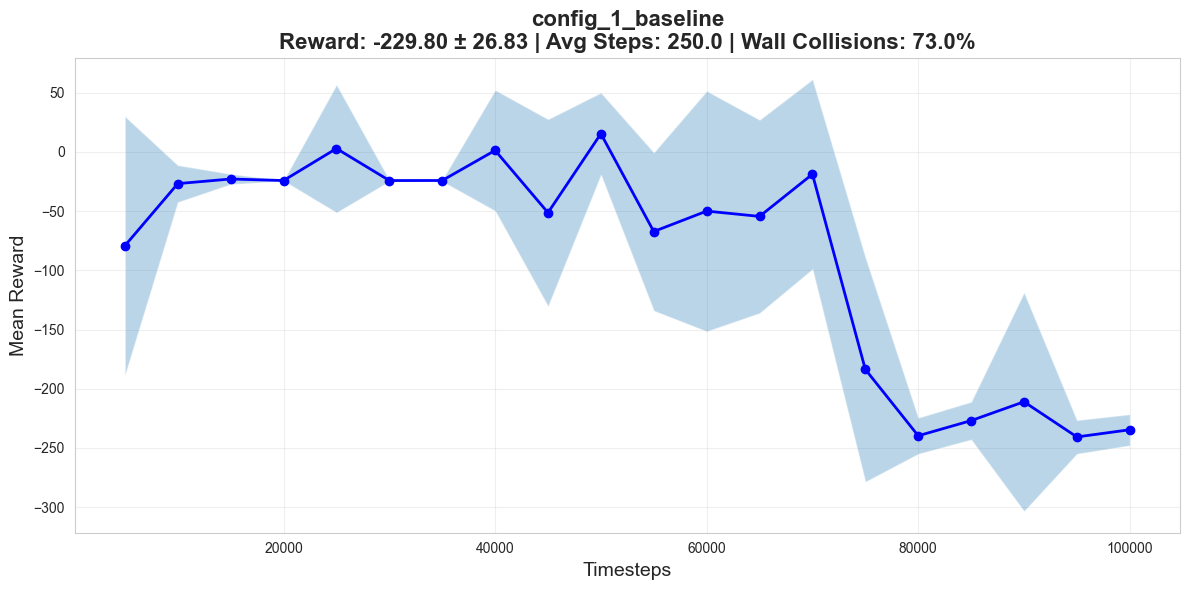


RESULTS for config_1_baseline:
   Mean Reward: -229.80 ± 26.83
   Avg Episode Length: 250.0 steps
   Wall Collision Rate: 72.95%
   Scan Efficiency: 1.00%
   Avg Pickup Attempts: 89.29
   Avg Time to Find Survivor: 88.0 steps
   Training Time: 240.1s (4.0 min)
   Saved to: ../models/ppo\config_1_baseline


Progress: 2/11 configurations

Training: config_2_high_lr
📝 High LR - Compare with DQN config 2 (FIXED)

Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward = -137.31 ± 120.86

[Eval] Step  10000: Reward =  -13.17 ± 88.95

[Eval] Step  15000: Reward =  -58.93 ± 118.32

[Eval] Step  20000: Reward =  -15.60 ± 82.54

[Eval] Step  25000: Reward = -108.99 ± 72.26

[Eval] Step  30000: Reward =  -88.71 ± 33.29

[Eval] Step  35000: Reward = -201.44 ± 53.76

[Eval] Step  40000: Reward = -198.64 ± 76.17

[Eval] Step  45000: Reward = -252.93 ±  3.40

[Eval] Step  50000: Reward = -227.51 ± 15.54

[Eval] Step  55000: Reward = -112.00 ± 171.60

[Eval] Step  60000: Reward = -107.65 ± 169.62

[Eval] Step  65000: Reward =  -16.11 ± 158.12

[Eval] Step  70000: Reward =   33.64 ± 138.43

[Eval] Step  75000: Reward =  -98.74 ± 118.26

[Eval] Step  80000: Reward = -106.60 ± 116.04

[Eval] Step  85000: Reward =  -20.60 ± 114.41

[Eval] Step  90000: Reward =  -22.97 ± 99.48

[Eval] Step  95000: Reward =  -43.32 ± 73.20

[Eval] Step 100000: Reward =  -17.78 ± 89.45


Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 61 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 2: Steps: 250 | Wall Collisions: 97.19% | Scan Eff: 0.00%
Calculating episode performance metrics...
  Episode 1: Steps: 61 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 2: Steps: 250 | Wall Collisions: 97.19% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 96.37% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 52.94%
  Episode 3: Steps: 250 | Wall Collisions: 96.37% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 52.94%
  Episode 5: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%

📊 Evaluation Summary:
   Average Episode Length: 245.1 steps
   Wall Collision Rate: 15.15%
   Scan Efficiency: 14.01%
   Avg Pickup Attempts: 48.80
   Avg Time to Find Survivor: 44.1 steps (10/100 f

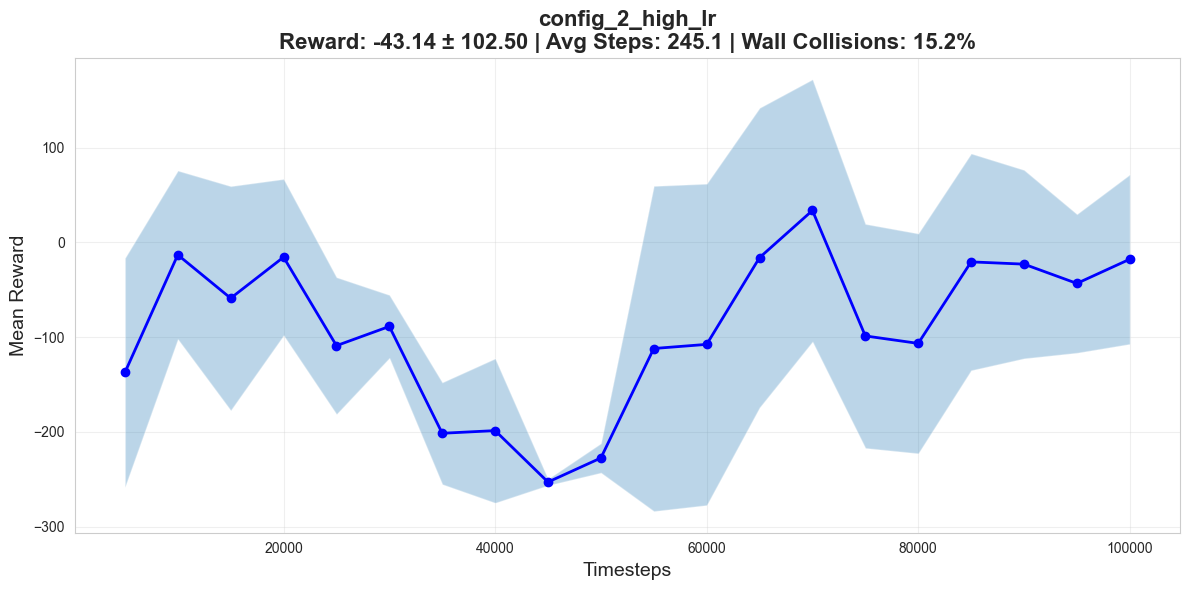


RESULTS for config_2_high_lr:
   Mean Reward: -43.14 ± 102.50
   Avg Episode Length: 245.1 steps
   Wall Collision Rate: 15.15%
   Scan Efficiency: 14.01%
   Avg Pickup Attempts: 48.80
   Avg Time to Find Survivor: 44.1 steps
   Training Time: 268.6s (4.5 min)
   Saved to: ../models/ppo\config_2_high_lr


Progress: 3/11 configurations

Training: config_3_low_lr
📝 Low LR - Compare with DQN config 3 (FIXED)

Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward =  -24.67 ±  0.34

[Eval] Step  10000: Reward =  -24.60 ±  0.22

[Eval] Step  15000: Reward = -148.03 ± 126.27

[Eval] Step  20000: Reward =  -23.94 ±  0.43

[Eval] Step  25000: Reward = -251.85 ±  0.77

[Eval] Step  30000: Reward = -213.98 ± 65.96

[Eval] Step  35000: Reward = -159.03 ± 86.39

[Eval] Step  40000: Reward = -189.27 ± 64.19

[Eval] Step  45000: Reward =  -90.71 ± 90.94

[Eval] Step  50000: Reward = -141.74 ± 102.53

[Eval] Step  55000: Reward =  -24.47 ±  0.30

[Eval] Step  60000: Reward =  -11.75 ±  3.12

[Eval] Step  65000: Reward =  -24.52 ±  0.50

[Eval] Step  70000: Reward = -222.06 ± 54.81

[Eval] Step  75000: Reward =  -24.72 ±  0.20

[Eval] Step  80000: Reward =  -24.85 ±  0.10

[Eval] Step  85000: Reward =  -24.69 ±  0.19

[Eval] Step  90000: Reward =  -24.77 ±  0.13

[Eval] Step  95000: Reward =  -24.75 ±  0.17

[Eval] Step 100000: Reward =  -24.49 ±  0.45


Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%
  Episode 5: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 100.00%

📊 Evaluation Summary:
   Average Episode Length: 250.0 steps
   Wall Collision Rate: 0.00%
   Scan Efficiency: 6.00%
   Avg Pickup Attempts: 0.00
   Avg Time to Find Survivor: 2.0 steps (2/100 found)

📊 

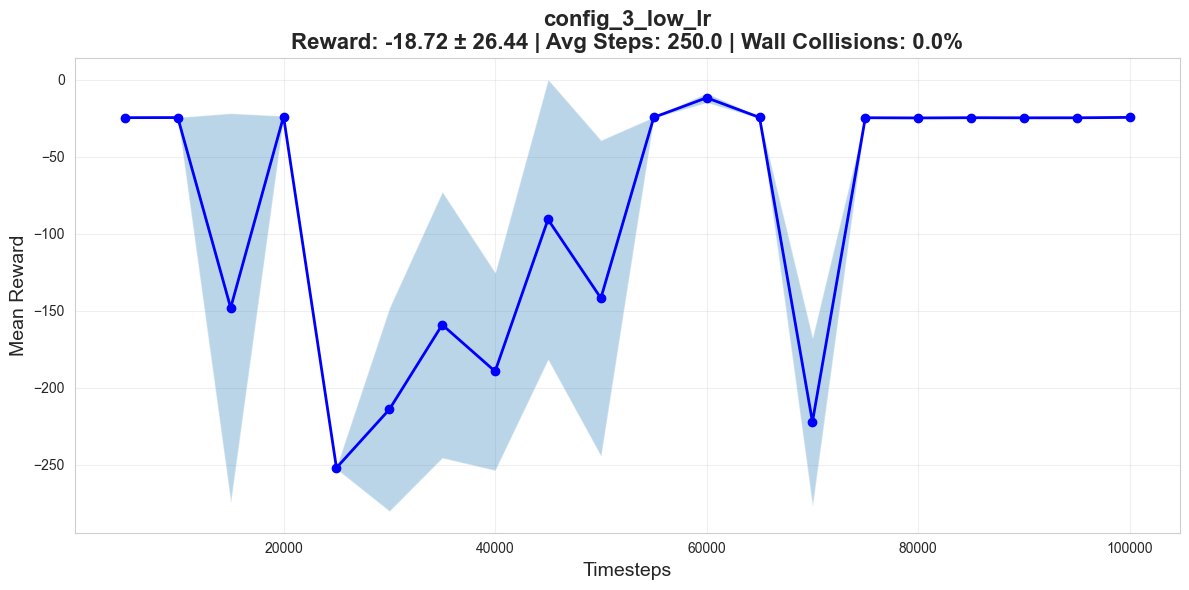


RESULTS for config_3_low_lr:
   Mean Reward: -18.72 ± 26.44
   Avg Episode Length: 250.0 steps
   Wall Collision Rate: 0.00%
   Scan Efficiency: 6.00%
   Avg Pickup Attempts: 0.00
   Avg Time to Find Survivor: 2.0 steps
   Training Time: 322.9s (5.4 min)
   Saved to: ../models/ppo\config_3_low_lr


Progress: 4/11 configurations

Training: config_4_large_batch
📝 Large Batch - Stable gradients

Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward =   -9.88 ± 18.43

[Eval] Step  10000: Reward =  -24.70 ±  0.20

[Eval] Step  15000: Reward =  -24.53 ±  0.25

[Eval] Step  20000: Reward =  -24.77 ±  0.13

[Eval] Step  25000: Reward =  -11.17 ± 41.06

[Eval] Step  30000: Reward =  -10.88 ± 40.80

[Eval] Step  35000: Reward =    1.36 ± 12.75

[Eval] Step  40000: Reward =  -15.42 ±  3.85

[Eval] Step  45000: Reward =    1.58 ± 43.07

[Eval] Step  50000: Reward =   -9.97 ±  5.72

[Eval] Step  55000: Reward =  -12.75 ±  6.90

[Eval] Step  60000: Reward =    0.94 ± 26.23

[Eval] Step  65000: Reward =    7.66 ± 34.35

[Eval] Step  70000: Reward =   13.91 ± 31.63

[Eval] Step  75000: Reward =   -4.09 ± 58.42

[Eval] Step  80000: Reward =   -9.69 ± 71.50

[Eval] Step  85000: Reward =  -30.17 ± 93.09

[Eval] Step  90000: Reward =  -64.78 ± 123.09

[Eval] Step  95000: Reward =  -75.26 ± 118.83

[Eval] Step 100000: Reward =  -50.50 ± 102.04


Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 52.31%
  Episode 3: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 81.22%
  Episode 2: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 52.31%
  Episode 3: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 81.22%
  Episode 4: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 67.77% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 67.77% | Scan Eff: 0.00%

📊 Evaluation Summary:
   Average Episode Length: 250.0 steps
   Wall Collision Rate: 24.43%
   Scan Efficiency: 33.53%
   Avg Pickup Attempts: 0.00
   Avg Time to Find Survivor: 110.9 steps (15/100 fou

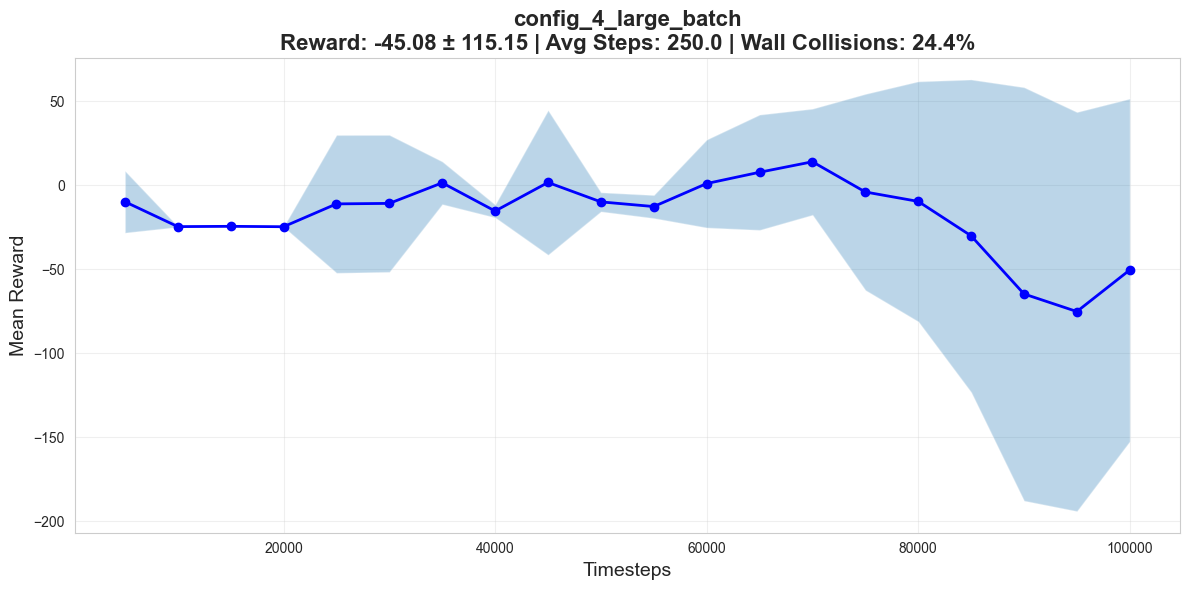


RESULTS for config_4_large_batch:
   Mean Reward: -45.08 ± 115.15
   Avg Episode Length: 250.0 steps
   Wall Collision Rate: 24.43%
   Scan Efficiency: 33.53%
   Avg Pickup Attempts: 0.00
   Avg Time to Find Survivor: 110.9 steps
   Training Time: 266.2s (4.4 min)
   Saved to: ../models/ppo\config_4_large_batch


Progress: 5/11 configurations

Training: config_5_small_batch
📝 Small Batch - Fast updates

Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward =    2.80 ± 52.93

[Eval] Step  10000: Reward =  -63.62 ± 99.95

[Eval] Step  15000: Reward =  -33.29 ± 91.23

[Eval] Step  20000: Reward =  -97.72 ± 107.98

[Eval] Step  25000: Reward = -111.69 ± 102.28

[Eval] Step  30000: Reward =  -50.84 ± 90.47

[Eval] Step  35000: Reward =  -89.97 ± 110.17

[Eval] Step  40000: Reward = -140.44 ± 120.94

[Eval] Step  45000: Reward =  -96.39 ± 104.45

[Eval] Step  50000: Reward = -144.29 ± 107.86

[Eval] Step  55000: Reward = -229.10 ± 49.94

[Eval] Step  60000: Reward = -212.00 ± 107.05

[Eval] Step  65000: Reward = -232.36 ± 54.07

[Eval] Step  70000: Reward = -220.10 ± 56.40

[Eval] Step  75000: Reward =  -71.95 ± 168.55

[Eval] Step  80000: Reward = -104.04 ± 161.12

[Eval] Step  85000: Reward = -208.19 ± 96.90

[Eval] Step  90000: Reward = -230.93 ± 17.47

[Eval] Step  95000: Reward = -157.36 ± 150.38

[Eval] Step 100000: Reward = -149.78 ± 122.78


Final evaluation (100 episodes)...
Calculating episode performance metrics...
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 1: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 21.29% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 21.29% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 97.19% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 97.19% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 97.99% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 97.99% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 97.19% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 97.19% | Scan Eff: 0.00%

📊 Evaluation Summary:
   Average Episode Length: 132.0 steps
   Wall Collision Rate: 40.52%
   Scan Efficiency: 1.00%
   Avg Pickup Attempts: 1.16
   Avg Time to Find Survivor: 8.7 steps (66/100 foun

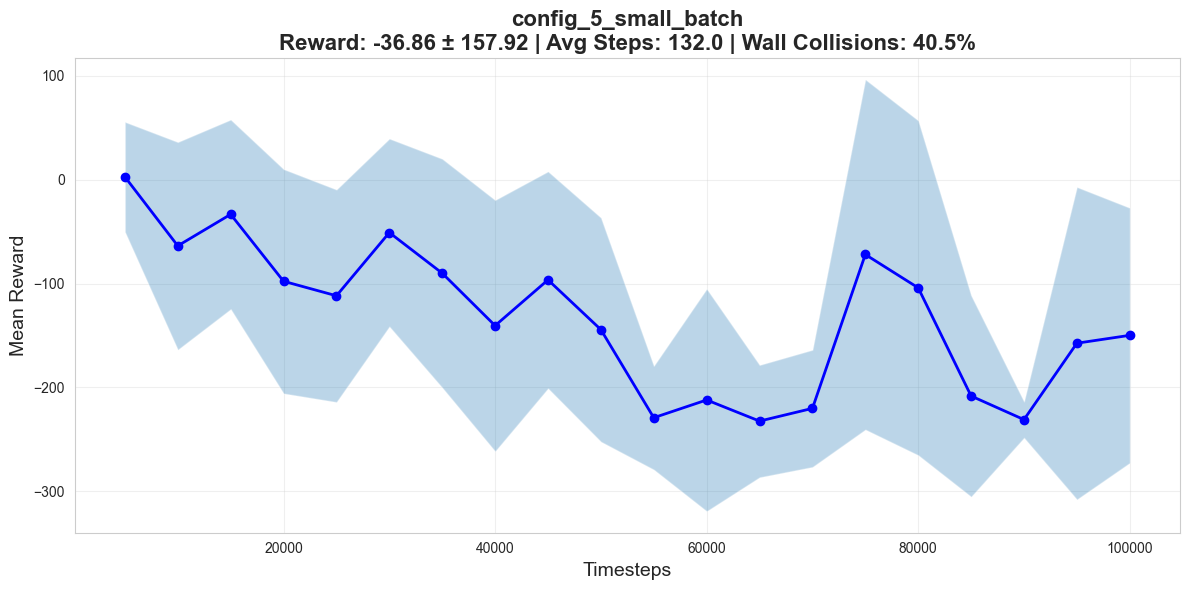


RESULTS for config_5_small_batch:
   Mean Reward: -36.86 ± 157.92
   Avg Episode Length: 132.0 steps
   Wall Collision Rate: 40.52%
   Scan Efficiency: 1.00%
   Avg Pickup Attempts: 1.16
   Avg Time to Find Survivor: 8.7 steps
   Training Time: 711.0s (11.8 min)
   Saved to: ../models/ppo\config_5_small_batch


Progress: 6/11 configurations

Training: config_6_low_gamma
📝 Low Gamma - Compare with DQN config 6 (FIXED)

Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward = -175.44 ± 114.47

[Eval] Step  10000: Reward =  -57.90 ± 87.30

[Eval] Step  15000: Reward =  -18.87 ± 42.69

[Eval] Step  20000: Reward =  -14.22 ±  9.49

[Eval] Step  25000: Reward =    8.82 ± 16.98

[Eval] Step  30000: Reward =  -28.75 ± 42.48

[Eval] Step  35000: Reward =  -21.51 ± 16.64

[Eval] Step  40000: Reward =  -26.27 ± 17.18

[Eval] Step  45000: Reward =    7.81 ± 44.79

[Eval] Step  50000: Reward =  -55.69 ± 72.14

[Eval] Step  55000: Reward =   -5.61 ± 76.00

[Eval] Step  60000: Reward =  -62.51 ± 157.36

[Eval] Step  65000: Reward =  -32.78 ± 139.93

[Eval] Step  70000: Reward =  -26.65 ± 131.69

[Eval] Step  75000: Reward = -164.08 ± 126.06

[Eval] Step  80000: Reward = -101.48 ± 129.09

[Eval] Step  85000: Reward = -223.95 ± 10.01

[Eval] Step  90000: Reward = -200.14 ± 93.41

[Eval] Step  95000: Reward = -213.56 ± 72.25

[Eval] Step 100000: Reward = -136.28 ± 154.47


Final evaluation (100 episodes)...
Calculating episode performance metrics...
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 97.59% | Scan Eff: 0.00%
  Episode 1: Steps: 250 | Wall Collisions: 97.59% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 93.15% | Scan Eff: 0.00%
  Episode 3: Steps: 12 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: Steps: 26 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: Steps: 12 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 93.15% | Scan Eff: 0.00%
  Episode 3: Steps: 12 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: Steps: 26 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: Steps: 12 | Wall Collisions: 0.00% | Scan Eff: 0.00%

📊 Evaluation Summary:
   Average Episode Length: 152.9 steps
   Wall Collision Rate: 51.32%
   Scan Efficiency: 0.00%
   Avg Pickup Attempts: 6.27
   Avg Time to Find Survivor: 18.8 steps (65/100 found)

📊 Eva

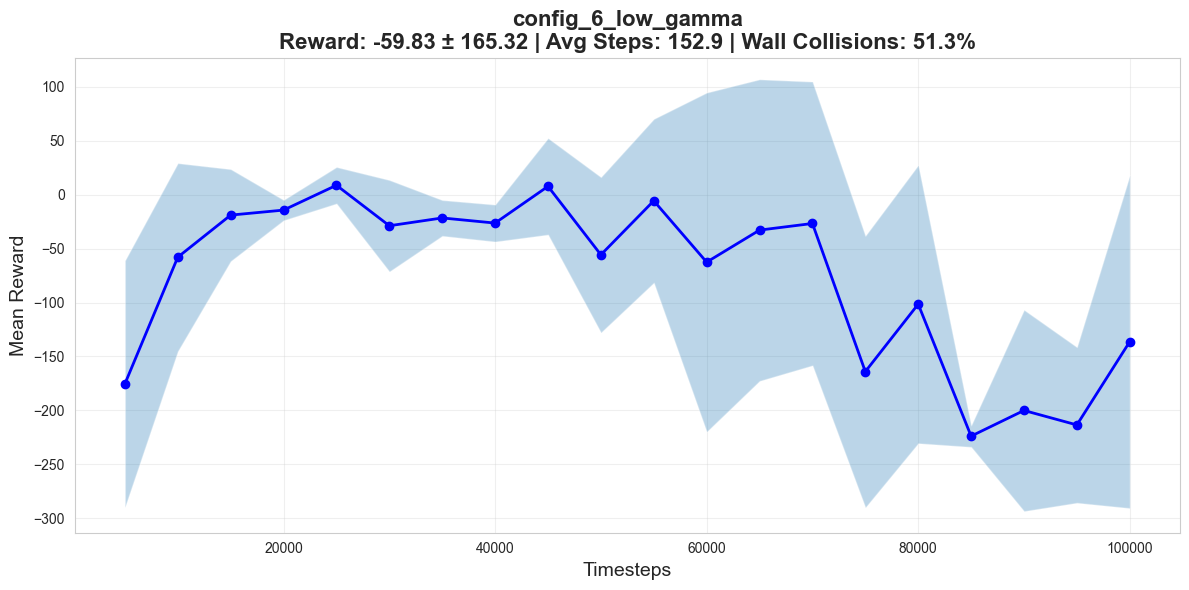


RESULTS for config_6_low_gamma:
   Mean Reward: -59.83 ± 165.32
   Avg Episode Length: 152.9 steps
   Wall Collision Rate: 51.32%
   Scan Efficiency: 0.00%
   Avg Pickup Attempts: 6.27
   Avg Time to Find Survivor: 18.8 steps
   Training Time: 470.1s (7.8 min)
   Saved to: ../models/ppo\config_6_low_gamma


Progress: 7/11 configurations

Training: config_7_high_gamma
📝 High Gamma - Compare with DQN config 7

Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward =  -10.88 ± 40.96

[Eval] Step  10000: Reward =  -30.20 ± 19.77

[Eval] Step  15000: Reward =  -11.00 ± 41.00

[Eval] Step  20000: Reward =  -29.75 ± 14.95

[Eval] Step  25000: Reward =  -37.92 ± 74.28

[Eval] Step  30000: Reward =  -41.28 ± 118.13

[Eval] Step  35000: Reward =  -18.33 ± 89.94

[Eval] Step  40000: Reward =   23.21 ± 105.55

[Eval] Step  45000: Reward =   40.46 ± 107.01

[Eval] Step  50000: Reward =   70.45 ± 32.43

[Eval] Step  55000: Reward = -156.82 ± 112.22

[Eval] Step  60000: Reward = -229.97 ± 30.36

[Eval] Step  65000: Reward = -245.43 ± 11.29

[Eval] Step  70000: Reward =  -90.68 ± 142.91

[Eval] Step  75000: Reward = -241.35 ± 12.18

[Eval] Step  80000: Reward = -173.97 ± 114.35

[Eval] Step  85000: Reward = -172.75 ± 114.36

[Eval] Step  90000: Reward = -200.21 ± 80.36

[Eval] Step  95000: Reward = -167.04 ± 105.50

[Eval] Step 100000: Reward = -133.10 ± 139.44


Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 93.17% | Scan Eff: 0.00%
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 93.17% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 91.77% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 91.77% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 91.77% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 91.77% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 96.80% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 92.77% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 96.80% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 92.77% | Scan Eff: 0.00%

📊 Evaluation Summary:
   Average Episode Length: 235.8 steps
   Wall Collision Rate: 72.81%
   Scan Efficiency: 0.00%
   Avg Pickup Attempts: 17.29
   Avg Time to Find Survivor: 24.0 steps (50/100 

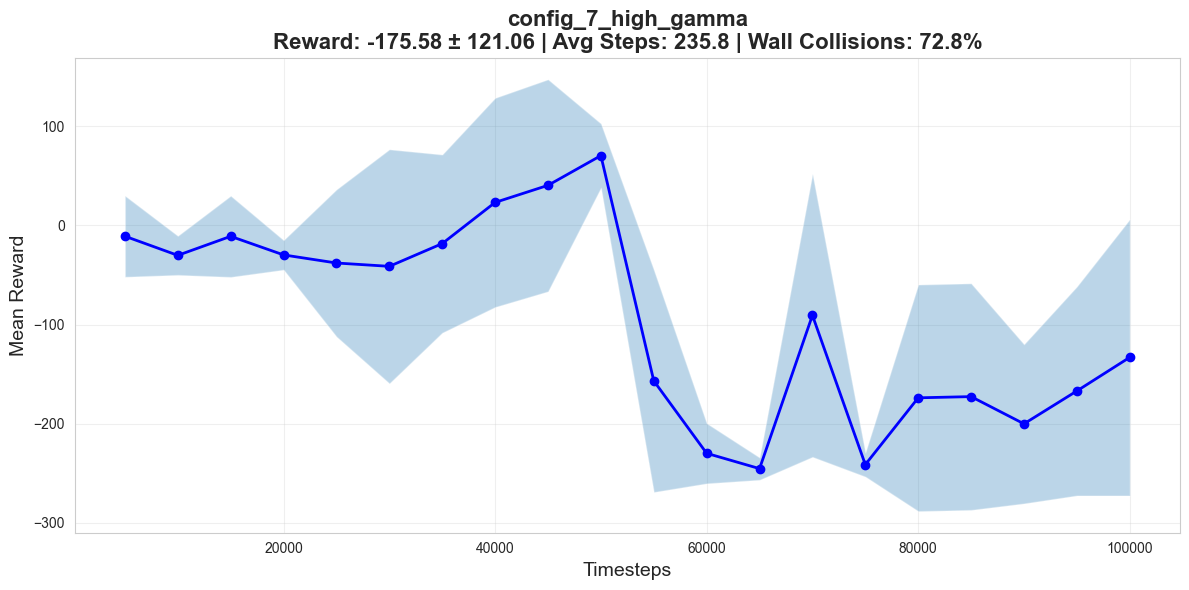


RESULTS for config_7_high_gamma:
   Mean Reward: -175.58 ± 121.06
   Avg Episode Length: 235.8 steps
   Wall Collision Rate: 72.81%
   Scan Efficiency: 0.00%
   Avg Pickup Attempts: 17.29
   Avg Time to Find Survivor: 24.0 steps
   Training Time: 276.8s (4.6 min)
   Saved to: ../models/ppo\config_7_high_gamma


Progress: 8/11 configurations

Training: config_8_high_entropy
📝 High Entropy - More exploration

Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward = -183.50 ± 109.48

[Eval] Step  10000: Reward = -127.19 ± 128.02

[Eval] Step  15000: Reward = -174.99 ± 106.73

[Eval] Step  20000: Reward = -101.19 ± 108.50

[Eval] Step  25000: Reward = -130.65 ± 113.21

[Eval] Step  30000: Reward = -145.13 ± 116.32

[Eval] Step  35000: Reward = -233.20 ± 11.23

[Eval] Step  40000: Reward = -240.36 ± 10.09

[Eval] Step  45000: Reward = -239.07 ± 12.42

[Eval] Step  50000: Reward = -241.01 ± 13.20

[Eval] Step  55000: Reward = -236.85 ± 10.93

[Eval] Step  60000: Reward = -229.23 ± 11.15

[Eval] Step  65000: Reward = -238.16 ± 13.08

[Eval] Step  70000: Reward = -248.81 ± 10.79

[Eval] Step  75000: Reward = -235.65 ± 19.30

[Eval] Step  80000: Reward = -235.35 ± 14.23

[Eval] Step  85000: Reward = -230.14 ± 23.27

[Eval] Step  90000: Reward = -224.04 ± 42.15

[Eval] Step  95000: Reward = -179.70 ± 92.20

[Eval] Step 100000: Reward = -242.39 ± 11.22


Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 94.76% | Scan Eff: 0.00%
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 94.76% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: Steps: 118 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: Steps: 118 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%

📊 Evaluation Summary:
   Average Episode Length: 211.4 steps
   Wall Collision Rate: 41.63%
   Scan Efficiency: 0.00%
   Avg Pickup Attempts: 91.79
   Avg Time to Find Survivor: 89.3 steps (45/100 found)



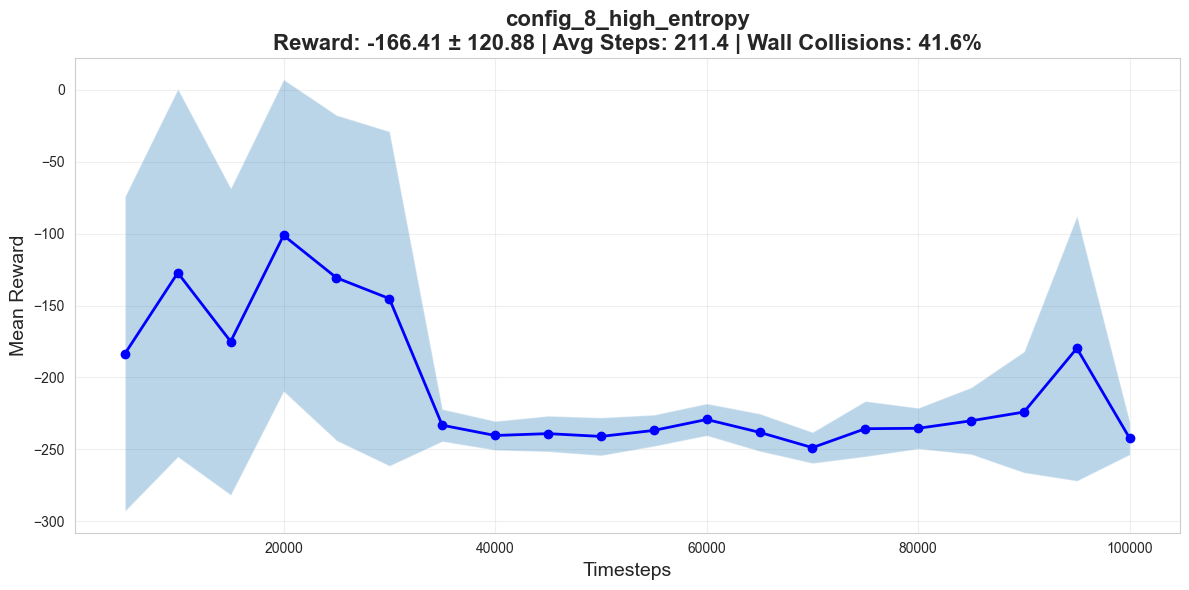


RESULTS for config_8_high_entropy:
   Mean Reward: -166.41 ± 120.88
   Avg Episode Length: 211.4 steps
   Wall Collision Rate: 41.63%
   Scan Efficiency: 0.00%
   Avg Pickup Attempts: 91.79
   Avg Time to Find Survivor: 89.3 steps
   Training Time: 344.8s (5.7 min)
   Saved to: ../models/ppo\config_8_high_entropy


Progress: 9/11 configurations

Training: config_9_low_entropy
📝 Low Entropy - Pure exploitation

Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward =  -55.18 ± 98.41

[Eval] Step  10000: Reward =  -33.84 ± 46.42

[Eval] Step  15000: Reward =  -14.15 ± 11.61

[Eval] Step  20000: Reward =  -52.07 ± 103.84

[Eval] Step  25000: Reward =  -10.60 ± 40.51

[Eval] Step  30000: Reward =  -10.89 ± 40.80

[Eval] Step  35000: Reward =  -24.13 ±  0.32

[Eval] Step  40000: Reward =    3.36 ± 54.33

[Eval] Step  45000: Reward =  -18.87 ± 13.41

[Eval] Step  50000: Reward =  -11.89 ± 41.42

[Eval] Step  55000: Reward =  -10.42 ± 51.32

[Eval] Step  60000: Reward =  -45.83 ± 40.81

[Eval] Step  65000: Reward =  -10.94 ± 17.61

[Eval] Step  70000: Reward =  -24.04 ±  0.32

[Eval] Step  75000: Reward =  -69.29 ± 92.30

[Eval] Step  80000: Reward =  -44.20 ± 79.01

[Eval] Step  85000: Reward =  -68.07 ± 98.02

[Eval] Step  90000: Reward =  -10.18 ± 65.45

[Eval] Step  95000: Reward =  -34.73 ± 80.54

[Eval] Step 100000: Reward =  -52.93 ± 91.78


Final evaluation (100 episodes)...
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 94.57% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 87.24%
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 94.57% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 87.24%
  Episode 3: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 20.65%
  Episode 4: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 20.65%
  Episode 4: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 6.64%
  Episode 5: Steps: 250 | Wall Collisions: 0.00% | Scan Eff: 6.64%

📊 Evaluation Summary:
   Average Episode Length: 250.0 steps
   Wall Collision Rate: 21.97%
   Scan Efficiency: 11.26%
   Avg Pickup Attempts: 0.00
   Avg Time to Find Survivor: 217.0 steps (2/100 foun

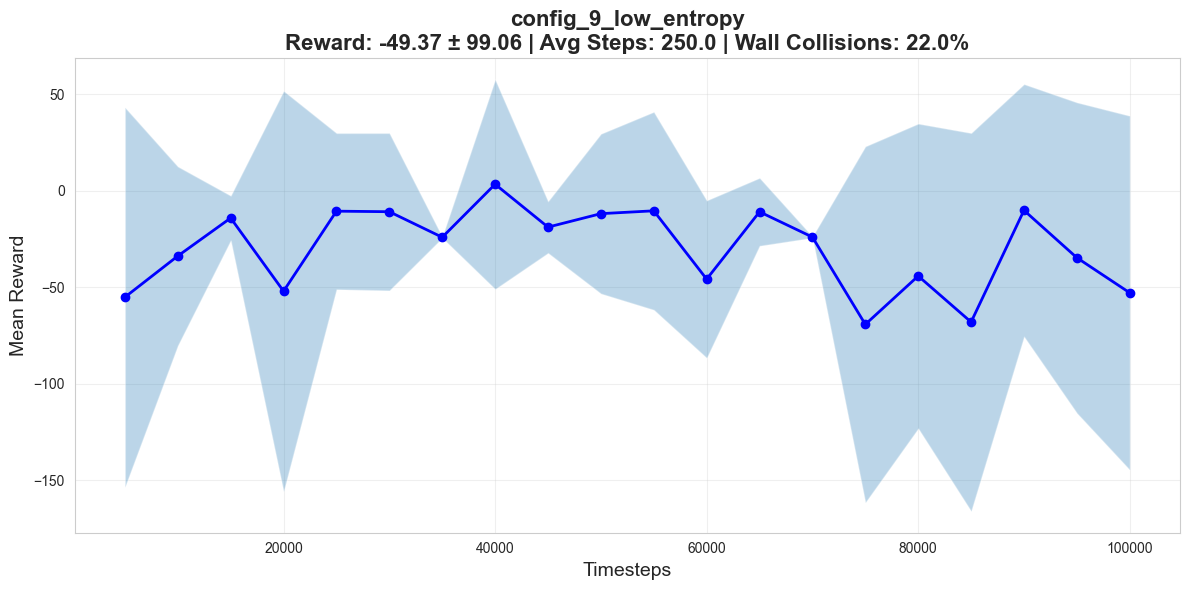


RESULTS for config_9_low_entropy:
   Mean Reward: -49.37 ± 99.06
   Avg Episode Length: 250.0 steps
   Wall Collision Rate: 21.97%
   Scan Efficiency: 11.26%
   Avg Pickup Attempts: 0.00
   Avg Time to Find Survivor: 217.0 steps
   Training Time: 740.7s (12.3 min)
   Saved to: ../models/ppo\config_9_low_entropy


Progress: 10/11 configurations

Training: config_10_optimized
📝 Optimized - Best guess for task

Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward = -111.87 ± 127.40

[Eval] Step  10000: Reward =  -46.88 ± 69.50

[Eval] Step  15000: Reward =  -74.15 ± 90.62

[Eval] Step  20000: Reward =  -49.35 ± 58.88

[Eval] Step  25000: Reward = -179.40 ± 104.41

[Eval] Step  30000: Reward = -121.36 ± 108.68

[Eval] Step  35000: Reward = -149.38 ± 109.05

[Eval] Step  40000: Reward = -240.71 ± 14.54

[Eval] Step  45000: Reward = -245.89 ± 12.04

[Eval] Step  50000: Reward = -225.62 ± 53.89

[Eval] Step  55000: Reward = -209.63 ± 72.86

[Eval] Step  60000: Reward = -238.17 ± 13.15

[Eval] Step  65000: Reward = -238.39 ± 14.71

[Eval] Step  70000: Reward = -152.92 ± 98.75

[Eval] Step  75000: Reward = -138.92 ± 122.59

[Eval] Step  80000: Reward = -178.36 ± 68.15

[Eval] Step  85000: Reward = -212.76 ± 55.10

[Eval] Step  90000: Reward = -213.18 ± 57.21

[Eval] Step  95000: Reward = -189.04 ± 81.79

[Eval] Step 100000: Reward = -109.73 ± 152.13


Final evaluation (100 episodes)...
Calculating episode performance metrics...
Calculating episode performance metrics...
  Episode 1: Steps: 250 | Wall Collisions: 95.98% | Scan Eff: 0.00%
  Episode 1: Steps: 250 | Wall Collisions: 95.98% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 95.58% | Scan Eff: 0.00%
  Episode 2: Steps: 250 | Wall Collisions: 95.58% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 97.99% | Scan Eff: 0.00%
  Episode 3: Steps: 250 | Wall Collisions: 97.99% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 97.59% | Scan Eff: 0.00%
  Episode 4: Steps: 250 | Wall Collisions: 97.59% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 97.99% | Scan Eff: 0.00%
  Episode 5: Steps: 250 | Wall Collisions: 97.99% | Scan Eff: 0.00%

📊 Evaluation Summary:
   Average Episode Length: 250.0 steps
   Wall Collision Rate: 82.05%
   Scan Efficiency: 2.00%
   Avg Pickup Attempts: 48.22
   Avg Time to Find Survivor: 114.0 steps (47/100

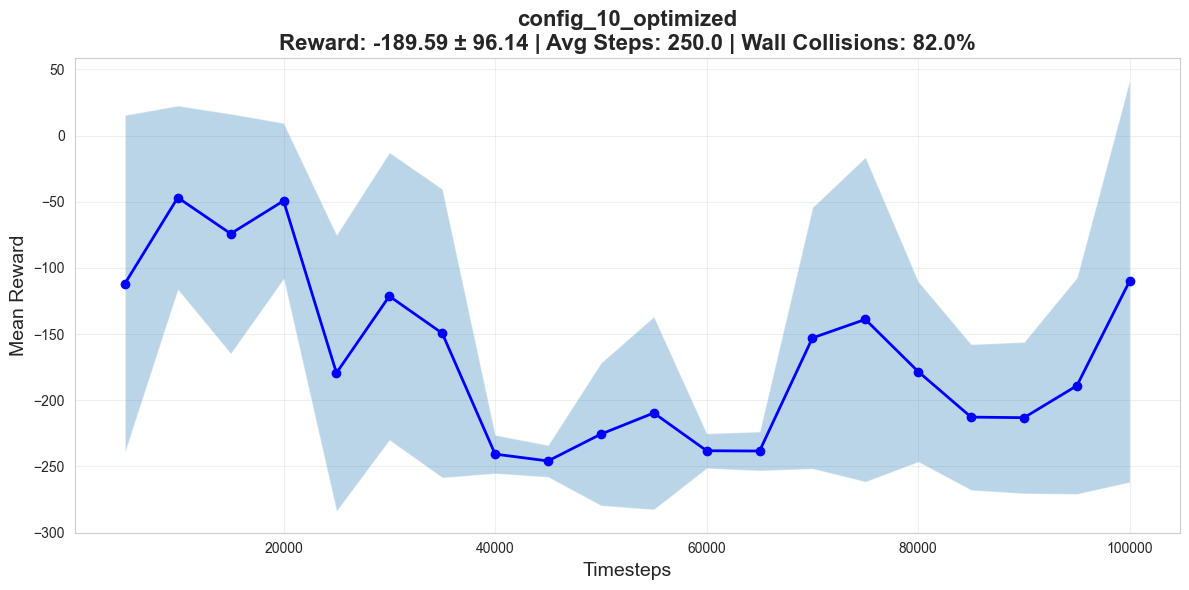


RESULTS for config_10_optimized:
   Mean Reward: -189.59 ± 96.14
   Avg Episode Length: 250.0 steps
   Wall Collision Rate: 82.05%
   Scan Efficiency: 2.00%
   Avg Pickup Attempts: 48.22
   Avg Time to Find Survivor: 114.0 steps
   Training Time: 187.0s (3.1 min)
   Saved to: ../models/ppo\config_10_optimized


Progress: 11/11 configurations

Training: config_11_many_epochs
📝 Many Epochs - Sample efficient

Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward =  -90.57 ± 99.61

[Eval] Step  10000: Reward =  -72.05 ± 122.30

[Eval] Step  15000: Reward =  -23.53 ±  3.02

[Eval] Step  20000: Reward =  -22.03 ±  7.52

[Eval] Step  25000: Reward =   -5.32 ± 40.58

[Eval] Step  30000: Reward =  -24.32 ±  0.34

[Eval] Step  35000: Reward =   -6.65 ± 101.92

[Eval] Step  40000: Reward =  -45.73 ± 109.88

[Eval] Step  45000: Reward =  -47.36 ± 108.45

[Eval] Step  50000: Reward = -109.62 ± 160.35

[Eval] Step  55000: Reward = -128.13 ± 130.94

[Eval] Step  60000: Reward = -137.26 ± 148.01

[Eval] Step  65000: Reward = -144.70 ± 141.53

[Eval] Step  70000: Reward =  -96.73 ± 161.29

KeyboardInterrupt: 

In [16]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 6: TRAIN ALL CONFIGURATIONS
# ═══════════════════════════════════════════════════════════════════════
"""
MAIN TRAINING CELL - This will take a while!

Adjust total_timesteps based on your time:
- 50k = ~30-60 min total (quick test)
- 100k = ~1-2 hours total (recommended)
- 200k = ~2-4 hours total (better results)

You can also train individual configs by commenting out others
"""

# CONFIGURATION
TOTAL_TIMESTEPS = 100000  # Adjust this based on your compute time

print("\n" + "="*80)
print("PPO HYPERPARAMETER TUNING - FIRE RESCUE ENVIRONMENT")
print("="*80)
print(f"\nTotal Configs: {len(PPO_CONFIGS)}")
print(f"Timesteps per config: {TOTAL_TIMESTEPS:,}")
print(f"Total training timesteps: {TOTAL_TIMESTEPS * len(PPO_CONFIGS):,}")
print(f"\nThis will take approximately {(TOTAL_TIMESTEPS * len(PPO_CONFIGS)) / 50000:.1f} hours")
print(f"    (Estimate: ~{TOTAL_TIMESTEPS / 50000 * 5:.0f} min per config)")
print("\n" + "="*80 + "\n")

# Train all configurations
all_results = []

for i, (config_name, config) in enumerate(PPO_CONFIGS.items(), 1):
    print(f"\nProgress: {i}/{len(PPO_CONFIGS)} configurations")
    
    try:
        results = train_ppo_config(config_name, config, TOTAL_TIMESTEPS)
        all_results.append(results)
    except Exception as e:
        print(f"ERROR training {config_name}: {e}")
        import traceback
        traceback.print_exc()
        continue

print("\n" + "="*80)
print("ALL TRAINING COMPLETE!")
print(f"   Trained {len(all_results)}/{len(PPO_CONFIGS)} configurations successfully")
print("="*80)

In [ ]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 7: GENERATE COMPARISON REPORT
# ═══════════════════════════════════════════════════════════════════════
"""
Generate comprehensive analysis and performance summary
"""

if len(all_results) == 0:
    print("No results to compare!")
else:
    # Create comparison directory
    comp_dir = "../models/ppo/comparison"
    os.makedirs(comp_dir, exist_ok=True)
    
    # Sort by mean reward for analysis
    results_sorted = sorted(all_results, key=lambda x: x['mean_reward'], reverse=True)
    
    print("\n" + "="*80)
    print("📊 PPO HYPERPARAMETER TUNING - SUMMARY EVALUATION")
    print("="*80)
    
    # ─────────────────────────────────────────────────────────────────────
    # KEY OBSERVATIONS
    # ─────────────────────────────────────────────────────────────────────
    
    print("\n🔍 KEY OBSERVATIONS:\n")
    
    # 1. Learning Rate Analysis
    high_lr = next((r for r in all_results if r['config_name'] == 'config_2_high_lr'), None)
    low_lr = next((r for r in all_results if r['config_name'] == 'config_3_low_lr'), None)
    baseline = next((r for r in all_results if r['config_name'] == 'config_1_baseline'), None)
    
    if high_lr and low_lr and baseline:
        lr_values = [
            (high_lr['config']['learning_rate'], high_lr['mean_reward'], 'High LR'),
            (baseline['config']['learning_rate'], baseline['mean_reward'], 'Baseline'),
            (low_lr['config']['learning_rate'], low_lr['mean_reward'], 'Low LR')
        ]
        best_lr = max(lr_values, key=lambda x: x[1])
        print(f"1. LEARNING RATE: {best_lr[2]} ({best_lr[0]:.0e}) performed best ({best_lr[1]:.2f} reward)")
        if best_lr[2] == 'Baseline':
            print("   → Standard learning rate (3e-4) is well-suited for this task")
        elif best_lr[2] == 'High LR':
            print("   → Aggressive learning beneficial; PPO's clipping prevents instability")
        else:
            print("   → Conservative learning works best; task needs careful policy updates")
    
    # 2. Gamma Analysis
    low_gamma = next((r for r in all_results if r['config_name'] == 'config_6_low_gamma'), None)
    high_gamma = next((r for r in all_results if r['config_name'] == 'config_7_high_gamma'), None)
    
    if low_gamma and high_gamma and baseline:
        gamma_values = [
            (low_gamma['config']['gamma'], low_gamma['mean_reward'], 'Low γ (0.95)'),
            (baseline['config']['gamma'], baseline['mean_reward'], 'Baseline γ (0.99)'),
            (high_gamma['config']['gamma'], high_gamma['mean_reward'], 'High γ (0.995)')
        ]
        best_gamma = max(gamma_values, key=lambda x: x[1])
        print(f"\n2. DISCOUNT FACTOR (γ): {best_gamma[2]} achieved best performance ({best_gamma[1]:.2f} reward)")
        if best_gamma[0] >= 0.99:
            print("   → Long-term planning crucial; agent values future rewards highly")
        else:
            print("   → Short-term rewards sufficient; immediate actions more important")
    
    # 3. Batch Size Analysis
    large_batch = next((r for r in all_results if r['config_name'] == 'config_4_large_batch'), None)
    small_batch = next((r for r in all_results if r['config_name'] == 'config_5_small_batch'), None)
    
    if large_batch and small_batch and baseline:
        batch_values = [
            (small_batch['config']['batch_size'], small_batch['mean_reward'], 'Small (32)'),
            (baseline['config']['batch_size'], baseline['mean_reward'], 'Baseline (64)'),
            (large_batch['config']['batch_size'], large_batch['mean_reward'], 'Large (256)')
        ]
        best_batch = max(batch_values, key=lambda x: x[1])
        print(f"\n3. BATCH SIZE: {best_batch[2]} showed best results ({best_batch[1]:.2f} reward)")
        if best_batch[0] >= 128:
            print("   → Larger batches provide stable gradients and smooth learning")
        else:
            print("   → Smaller batches enable faster adaptation to environment dynamics")
    
    # 4. Entropy Coefficient (PPO-specific)
    high_ent = next((r for r in all_results if r['config_name'] == 'config_8_high_entropy'), None)
    low_ent = next((r for r in all_results if r['config_name'] == 'config_9_low_entropy'), None)
    
    if high_ent and low_ent and baseline:
        ent_values = [
            (low_ent['config']['ent_coef'], low_ent['mean_reward'], 'No exploration (0.0)'),
            (baseline['config']['ent_coef'], baseline['mean_reward'], 'Baseline (0.01)'),
            (high_ent['config']['ent_coef'], high_ent['mean_reward'], 'High exploration (0.1)')
        ]
        best_ent = max(ent_values, key=lambda x: x[1])
        print(f"\n4. EXPLORATION (Entropy): {best_ent[2]} was most effective ({best_ent[1]:.2f} reward)")
        if best_ent[0] >= 0.05:
            print("   → Strong exploration bonus helps discover diverse strategies")
        elif best_ent[0] == 0.0:
            print("   → Pure exploitation sufficient; optimal policy is straightforward")
        else:
            print("   → Moderate exploration balances discovery and exploitation")
    
    # 5. Overall Best Configuration
    best_overall = results_sorted[0]
    print(f"\n5. BEST OVERALL: {best_overall['config_name']}")
    print(f"   • Mean Reward: {best_overall['mean_reward']:.2f} ± {best_overall['std_reward']:.2f}")
    print(f"   • Avg Episode Length: {best_overall['avg_episode_length']:.1f} steps")
    print(f"   • Scan Efficiency: {best_overall['scan_efficiency']:.2%}")
    print(f"   • Avg Pickup Attempts: {best_overall['avg_pickup_attempts']:.2f}")
    print(f"   • Key Settings: LR={best_overall['config']['learning_rate']:.0e}, "
          f"γ={best_overall['config']['gamma']}, "
          f"Batch={best_overall['config']['batch_size']}, "
          f"Entropy={best_overall['config']['ent_coef']}")
    
    # ─────────────────────────────────────────────────────────────────────
    # PERFORMANCE TABLE (In training order)
    # ─────────────────────────────────────────────────────────────────────
    
    print("\n" + "="*80)
    print("📋 CONFIGURATION PERFORMANCE TABLE")
    print("="*80)
    print("\n| Config | Mean Reward | Scan Eff | Pickup Attempts | Episode Length |")
    print("|--------|-------------|----------|-----------------|----------------|")
    
    # Display in original training order
    for result in all_results:
        config_display = result['config_name'].replace('config_', '').replace('_', ' ').title()
        print(f"| {config_display:<30} | "
              f"{result['mean_reward']:>7.2f} ± {result['std_reward']:>4.2f} | "
              f"{result['scan_efficiency']:>7.1%} | "
              f"{result['avg_pickup_attempts']:>15.2f} | "
              f"{result['avg_episode_length']:>14.1f} |")
    
    print("\n" + "="*80)
    
    # Save detailed results
    with open(os.path.join(comp_dir, "all_results.json"), 'w') as f:
        json.dump(all_results, f, indent=4)
    
    # Save CSV
    import csv
    csv_path = os.path.join(comp_dir, "results_summary.csv")
    with open(csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Config', 'Mean Reward', 'Std Reward', 'Scan Efficiency', 'Pickup Attempts', 'Episode Length', 'Total Timesteps'])
        for result in all_results:
            writer.writerow([
                result['config_name'],
                f"{result['mean_reward']:.2f}",
                f"{result['std_reward']:.2f}",
                f"{result['scan_efficiency']:.3f}",
                f"{result['avg_pickup_attempts']:.2f}",
                f"{result['avg_episode_length']:.1f}",
                result['total_timesteps']
            ])
    
    print(f"\n💾 Results saved to:")
    print(f"   • JSON: {comp_dir}/all_results.json")
    print(f"   • CSV: {csv_path}")
    print("\n" + "="*80)


In [ ]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 8: COMPREHENSIVE VISUALIZATION
# ═══════════════════════════════════════════════════════════════════════
"""
Create all comparison visualizations in one comprehensive figure
"""

if len(all_results) > 0:
    # Create large figure with 2 rows: 4 plots top, 1 large plot bottom
    fig = plt.figure(figsize=(24, 14))
    gs = fig.add_gridspec(2, 4, height_ratios=[1, 1.2], hspace=0.35, wspace=0.35,
                          left=0.06, right=0.97, top=0.95, bottom=0.08)
    
    # Prepare data
    results_sorted = sorted(all_results, key=lambda x: x['mean_reward'], reverse=True)
    configs = [r['config_name'].replace('config_', '').replace('_', '\n') 
               for r in results_sorted]
    rewards = [r['mean_reward'] for r in results_sorted]
    scan_efficiencies = [r['scan_efficiency'] * 100 for r in results_sorted]  # Convert to percentage
    pickup_attempts = [r['avg_pickup_attempts'] for r in results_sorted]
    times = [r['training_time'] / 60 for r in results_sorted]
    colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(configs)))
    
    # ─────────────────────────────────────────────────────────────────────
    # TOP ROW: 4 comparison plots
    # ─────────────────────────────────────────────────────────────────────
    
    # Plot 1: Mean Rewards
    ax1 = fig.add_subplot(gs[0, 0])
    bars1 = ax1.barh(configs, rewards, color=colors, edgecolor='black', linewidth=1.5)
    ax1.set_xlabel('Mean Reward', fontsize=13, fontweight='bold')
    ax1.set_title('Mean Reward Comparison', fontsize=15, fontweight='bold', pad=10)
    ax1.grid(axis='x', alpha=0.3, linestyle='--')
    ax1.tick_params(axis='y', labelsize=9)
    ax1.tick_params(axis='x', labelsize=10)
    for bar, val in zip(bars1, rewards):
        ax1.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val:.1f}', 
                va='center', fontsize=10, fontweight='bold')
    ax1.invert_yaxis()  # Best on top
    
    # Plot 2: Scan Efficiency
    ax2 = fig.add_subplot(gs[0, 1])
    bars2 = ax2.barh(configs, scan_efficiencies, color=colors, edgecolor='black', linewidth=1.5)
    ax2.set_xlabel('Scan Efficiency (%)', fontsize=13, fontweight='bold')
    ax2.set_title('Scan Efficiency', fontsize=15, fontweight='bold', pad=10)
    ax2.grid(axis='x', alpha=0.3, linestyle='--')
    ax2.tick_params(axis='y', labelsize=9)
    ax2.tick_params(axis='x', labelsize=10)
    ax2.set_xlim(0, 100)
    for bar, val in zip(bars2, scan_efficiencies):
        ax2.text(val + 1, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', 
                va='center', fontsize=10, fontweight='bold')
    ax2.invert_yaxis()  # Best on top
    
    # Plot 3: Training Time
    ax3 = fig.add_subplot(gs[0, 2])
    bars3 = ax3.barh(configs, times, color=colors, edgecolor='black', linewidth=1.5)
    ax3.set_xlabel('Training Time (min)', fontsize=13, fontweight='bold')
    ax3.set_title('Training Time', fontsize=15, fontweight='bold', pad=10)
    ax3.grid(axis='x', alpha=0.3, linestyle='--')
    ax3.tick_params(axis='y', labelsize=9)
    ax3.tick_params(axis='x', labelsize=10)
    for bar, val in zip(bars3, times):
        ax3.text(val + 0.2, bar.get_y() + bar.get_height()/2, f'{val:.1f}', 
                va='center', fontsize=10, fontweight='bold')
    ax3.invert_yaxis()  # Best on top
    
    # Plot 4: Learning Curves (Top 5)
    ax4 = fig.add_subplot(gs[0, 3])
    for i, result in enumerate(results_sorted[:5]):
        if 'eval_timesteps' in result and len(result['eval_timesteps']) > 0:
            label = result['config_name'].replace('config_', '').replace('_', ' ').title()
            ax4.plot(result['eval_timesteps'], result['eval_rewards'], 
                    label=label, linewidth=2.5, marker='o', markersize=6)
    ax4.set_xlabel('Timesteps', fontsize=13, fontweight='bold')
    ax4.set_ylabel('Mean Reward', fontsize=13, fontweight='bold')
    ax4.set_title('Learning Curves (Top 5)', fontsize=15, fontweight='bold', pad=10)
    ax4.legend(loc='best', fontsize=10, framealpha=0.95)
    ax4.grid(True, alpha=0.3, linestyle='--')
    ax4.tick_params(axis='both', labelsize=10)
    
    # ─────────────────────────────────────────────────────────────────────
    # BOTTOM ROW: Hyperparameter correlation analysis (spans full width)
    # ─────────────────────────────────────────────────────────────────────
    
    ax5 = fig.add_subplot(gs[1, :])
    
    # Extract hyperparameters and performance
    lrs = [r['config']['learning_rate'] for r in results_sorted]
    gammas = [r['config']['gamma'] for r in results_sorted]
    batches = [r['config']['batch_size'] for r in results_sorted]
    n_steps = [r['config']['n_steps'] for r in results_sorted]
    n_epochs = [r['config']['n_epochs'] for r in results_sorted]
    ent_coefs = [r['config']['ent_coef'] for r in results_sorted]
    rewards_sorted = [r['mean_reward'] for r in results_sorted]
    
    # Create positions for grouped bars
    x = np.arange(len(results_sorted))
    width = 0.14
    
    # Normalize values to 0-1 for comparison
    norm_lrs = [(np.log10(lr) - np.log10(min(lrs))) / (np.log10(max(lrs)) - np.log10(min(lrs))) if max(lrs) != min(lrs) else 0.5 for lr in lrs]
    norm_gammas = [(g - min(gammas)) / (max(gammas) - min(gammas)) if max(gammas) != min(gammas) else 0.5 for g in gammas]
    norm_batches = [(b - min(batches)) / (max(batches) - min(batches)) if max(batches) != min(batches) else 0.5 for b in batches]
    norm_epochs = [(e - min(n_epochs)) / (max(n_epochs) - min(n_epochs)) if max(n_epochs) != min(n_epochs) else 0.5 for e in n_epochs]
    norm_ent = [(e - min(ent_coefs)) / (max(ent_coefs) - min(ent_coefs)) if max(ent_coefs) != min(ent_coefs) else 0.5 for e in ent_coefs]
    
    # Plot grouped bars
    ax5.bar(x - 2*width, norm_lrs, width, label='LR (norm)', alpha=0.85, color='#e74c3c', edgecolor='black', linewidth=0.5)
    ax5.bar(x - width, norm_gammas, width, label='Gamma (norm)', alpha=0.85, color='#3498db', edgecolor='black', linewidth=0.5)
    ax5.bar(x, norm_batches, width, label='Batch Size (norm)', alpha=0.85, color='#2ecc71', edgecolor='black', linewidth=0.5)
    ax5.bar(x + width, norm_epochs, width, label='Epochs (norm)', alpha=0.85, color='#f39c12', edgecolor='black', linewidth=0.5)
    ax5.bar(x + 2*width, norm_ent, width, label='Entropy (norm)', alpha=0.85, color='#9b59b6', edgecolor='black', linewidth=0.5)
    
    # Overlay performance as line
    ax5_twin = ax5.twinx()
    ax5_twin.plot(x, rewards_sorted, 'ko-', linewidth=3.5, markersize=10, 
                  label='Mean Reward', markerfacecolor='red', markeredgewidth=2, markeredgecolor='black')
    ax5_twin.set_ylabel('Mean Reward', fontsize=14, fontweight='bold')
    ax5_twin.tick_params(axis='y', labelsize=11)
    
    # Formatting
    ax5.set_xlabel('Configuration (Sorted by Performance)', fontsize=14, fontweight='bold')
    ax5.set_ylabel('Normalized Hyperparameter Value', fontsize=14, fontweight='bold')
    ax5.set_title('Hyperparameter Settings vs Performance', fontsize=17, fontweight='bold', pad=15)
    ax5.set_xticks(x)
    ax5.set_xticklabels([c.replace('\n', ' ') for c in configs], rotation=45, ha='right', fontsize=10)
    ax5.legend(loc='upper left', fontsize=11, framealpha=0.95)
    ax5_twin.legend(loc='upper right', fontsize=11, framealpha=0.95)
    ax5.grid(axis='y', alpha=0.3, linestyle='--')
    ax5.set_ylim(0, 1.15)
    ax5.tick_params(axis='both', labelsize=11)
    
    plt.savefig('../models/ppo/comparison/ppo_comprehensive_analysis.png', dpi=200, bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ Comprehensive analysis plot saved to: ../models/ppo/comparison/ppo_comprehensive_analysis.png")

In [ ]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 9: BEST MODEL SUMMARY WITH VISUALIZATIONS
# ═══════════════════════════════════════════════════════════════════════
"""
Detailed summary of best model with dedicated visualizations
"""

if len(all_results) > 0:
    results_sorted = sorted(all_results, key=lambda x: x['mean_reward'], reverse=True)
    best = results_sorted[0]
    
    print("\n" + "="*80)
    print("BEST PERFORMING CONFIGURATION")
    print("="*80)
    print(f"\nConfig: {best['config_name']}")
    print(f"Description: {best['config']['description']}")
    print(f"\nPERFORMANCE METRICS:")
    print(f"   Mean Reward: {best['mean_reward']:.2f} ± {best['std_reward']:.2f}")
    print(f"   Avg Episode Length: {best['avg_episode_length']:.1f} steps")
    print(f"   Wall Collision Rate: {best['wall_collision_rate']:.2%}")
    print(f"   Scan Efficiency: {best['scan_efficiency']:.2%}")
    print(f"   Avg Pickup Attempts: {best['avg_pickup_attempts']:.2f}")
    if best['avg_time_to_find_survivor'] is not None:
        print(f"   Avg Time to Find Survivor: {best['avg_time_to_find_survivor']:.1f} steps")
    print(f"   Training Time: {best['training_time']/60:.1f} minutes")
    
    print(f"\nHYPERPARAMETERS:")
    print(f"   • Learning Rate: {best['config']['learning_rate']:.0e}")
    print(f"   • Gamma: {best['config']['gamma']}")
    print(f"   • Batch Size: {best['config']['batch_size']}")
    print(f"   • N Steps: {best['config']['n_steps']}")
    print(f"   • N Epochs: {best['config']['n_epochs']}")
    print(f"   • Clip Range: {best['config']['clip_range']}")
    print(f"   • GAE Lambda: {best['config']['gae_lambda']}")
    print(f"   • Entropy Coef: {best['config']['ent_coef']}")
    print(f"   • Network: {best['config']['policy_kwargs']['net_arch']}")
    
    print(f"\nModel saved at:")
    print(f"   ../models/ppo/{best['config_name']}/final_model.zip")
    print("="*80)
    
    # ─────────────────────────────────────────────────────────────────────
    # Create dedicated plots for best model
    # ─────────────────────────────────────────────────────────────────────
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Learning Curve with Confidence Interval
    ax1 = axes[0]
    if 'eval_timesteps' in best and len(best['eval_timesteps']) > 0:
        timesteps = best['eval_timesteps']
        rewards = best['eval_rewards']
        stds = best['eval_stds']
        
        ax1.plot(timesteps, rewards, 'b-', linewidth=3, marker='o', markersize=8, 
                label='Mean Reward')
        ax1.fill_between(timesteps, 
                        np.array(rewards) - np.array(stds),
                        np.array(rewards) + np.array(stds),
                        alpha=0.3, color='blue', label='±1 Std Dev')
        
        ax1.set_xlabel('Training Timesteps', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Evaluation Reward', fontsize=14, fontweight='bold')
        ax1.set_title(f'Best Model Learning Curve\n{best["config_name"]}', 
                     fontsize=16, fontweight='bold')
        ax1.legend(fontsize=12, loc='best')
        ax1.grid(True, alpha=0.3, linestyle='--')
        
        # Add annotations for first and last points
        ax1.annotate(f'Start: {rewards[0]:.1f}', 
                    xy=(timesteps[0], rewards[0]),
                    xytext=(10, -20), textcoords='offset points',
                    fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
        
        ax1.annotate(f'Final: {rewards[-1]:.1f}', 
                    xy=(timesteps[-1], rewards[-1]),
                    xytext=(-80, 20), textcoords='offset points',
                    fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.5', fc='lightgreen', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # Plot 2: Performance Metrics Comparison (Best vs Others)
    ax2 = axes[1]
    
    # Top 5 configs for comparison
    top5 = results_sorted[:5]
    config_names = [r['config_name'].replace('config_', '').replace('_', '\n') for r in top5]
    scan_effs = [r['scan_efficiency'] * 100 for r in top5]  # Convert to percentage
    pickup_atts = [r['avg_pickup_attempts'] for r in top5]
    mean_rewards = [r['mean_reward'] for r in top5]  # For annotation positioning
    
    x = np.arange(len(config_names))
    width = 0.35
    
    # Create bars
    bars1 = ax2.bar(x - width/2, scan_effs, width, label='Scan Efficiency (%)', 
                    color='steelblue', edgecolor='black', linewidth=2)
    
    # Create twin axis for pickup attempts
    ax2_twin = ax2.twinx()
    bars2 = ax2_twin.bar(x + width/2, pickup_atts, width, label='Pickup Attempts', 
                        color='coral', edgecolor='black', linewidth=2)
    
    # Highlight best model
    bars1[0].set_color('gold')
    bars1[0].set_edgecolor('darkgoldenrod')
    bars1[0].set_linewidth(3)
    bars2[0].set_color('gold')
    bars2[0].set_edgecolor('darkgoldenrod')
    bars2[0].set_linewidth(3)
    
    # Add value labels
    for bar, val in zip(bars1, scan_effs):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    for bar, val in zip(bars2, pickup_atts):
        height = bar.get_height()
        ax2_twin.text(bar.get_x() + bar.get_width()/2., height,
                     f'{val:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Formatting
    ax2.set_xlabel('Configuration', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Scan Efficiency (%)', fontsize=14, fontweight='bold', color='steelblue')
    ax2_twin.set_ylabel('Avg Pickup Attempts', fontsize=14, fontweight='bold', color='coral')
    ax2.set_title('Performance Metrics: Best vs Top Competitors', fontsize=16, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(config_names, fontsize=10)
    ax2.legend(loc='upper left', fontsize=11)
    ax2_twin.legend(loc='upper right', fontsize=11)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    ax2.tick_params(axis='y', labelcolor='steelblue')
    ax2_twin.tick_params(axis='y', labelcolor='coral')
    
    # Add crown emoji annotation for best model
    ax2.text(0, max(scan_effs) * 1.05, '👑 BEST', ha='center', fontsize=14, 
            fontweight='bold', color='darkgoldenrod')
    
    plt.tight_layout()
    
    plt.savefig(f'../models/ppo/{best["config_name"]}/best_model_analysis.png', dpi=200, bbox_inches='tight')
    print(f"\nUse this model for your video demonstration!")
    
    plt.show()
    print(f"\nBest model plots saved to: ../models/ppo/{best['config_name']}/best_model_analysis.png")


In [ ]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 10: LOAD AND TEST BEST MODEL
# ═══════════════════════════════════════════════════════════════════════
"""
Load the best model and run a test episode
This shows you how to use the trained model with detailed performance metrics
"""

if len(all_results) > 0:
    print("\n" + "="*80)
    print("TESTING BEST MODEL")
    print("="*80)
    
    # Load best model
    best_config = results_sorted[0]['config_name']
    model_path = f"../models/ppo/{best_config}/final_model"
    
    print(f"\nLoading model from: {model_path}")
    best_model = PPO.load(model_path)
    
    # Create test environment
    test_env = FireRescueEnv()
    
    print(f"Running 5 test episodes...\n")
    
    for episode in range(5):
        obs, _ = test_env.reset()
        total_reward = 0
        steps = 0
        done = False
        
        while not done:
            action, _ = best_model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = test_env.step(action)
            total_reward += reward
            steps += 1
            done = terminated or truncated
        
        # Extract performance metrics from info
        wall_collision_rate = info.get('wall_collision_rate', 0) * 100
        scan_efficiency = info.get('scan_efficiency', 0) * 100
        time_to_find = info.get('time_to_find_survivor', None)
        pickup_attempts = info.get('pickup_attempts', 0)
        
        # Display episode metrics
        print(f"   Episode {episode+1}:")
        print(f"      Steps: {steps}")
        print(f"      Reward: {total_reward:>7.2f}")
        print(f"      Wall Collision Rate: {wall_collision_rate:>5.1f}%")
        print(f"      Scan Efficiency: {scan_efficiency:>5.1f}%")
        if time_to_find is not None:
            print(f"      Time to Find Survivor: {time_to_find} steps")
            # Calculate time to drop off (total steps - time to find)
            time_to_dropoff = steps - time_to_find
            print(f"      Time to Drop Off: {time_to_dropoff} steps")
        else:
            print(f"      Time to Find Survivor: Not found")
        print()
    
    test_env.close()
    print("=" * 80)


In [ ]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 9.5: ACTION DISTRIBUTION ANALYSIS
# ═══════════════════════════════════════════════════════════════════════
"""
Analyze action usage to verify agent uses all actions (not just movement)
This proves the agent is not suffering from action space collapse
"""

if len(all_results) > 0:
    print("\n" + "="*80)
    print("ACTION DISTRIBUTION ANALYSIS - BEST MODEL")
    print("="*80)
    
    # Load best model
    best_config = results_sorted[0]['config_name']
    model_path = f"../models/ppo/{best_config}/final_model"
    
    print(f"\nLoading model from: {model_path}")
    best_model = PPO.load(model_path)
    
    # Create test environment
    test_env = FireRescueEnv()
    
    # Action names
    action_names = {
        0: "UP",
        1: "DOWN", 
        2: "LEFT",
        3: "RIGHT",
        4: "SCAN",
        5: "PICKUP/DROP"
    }
    
    # Track actions across multiple episodes
    total_action_counts = {i: 0 for i in range(6)}
    total_steps = 0
    n_test_episodes = 20
    
    print(f"\nRunning {n_test_episodes} episodes to analyze action distribution...\n")
    
    for episode in range(n_test_episodes):
        obs, _ = test_env.reset()
        done = False
        
        while not done:
            action, _ = best_model.predict(obs, deterministic=True)
            action = int(action)  # Convert to int
            total_action_counts[action] += 1
            total_steps += 1
            
            obs, reward, terminated, truncated, info = test_env.step(action)
            done = terminated or truncated
    
    test_env.close()
    
    # Display results
    print(f"{'='*60}")
    print(f"ACTION DISTRIBUTION ({n_test_episodes} episodes, {total_steps} total steps)")
    print(f"{'='*60}")
    
    for action_id, count in total_action_counts.items():
        pct = (count / total_steps * 100) if total_steps > 0 else 0
        bar = '█' * int(pct / 2)  # Visual bar
        print(f"  {action_names[action_id]:12s} (Action {action_id}): {count:4d} times ({pct:5.1f}%) {bar}")
    
    # Check for action space collapse
    scan_pct = (total_action_counts[4] / total_steps * 100) if total_steps > 0 else 0
    pickup_pct = (total_action_counts[5] / total_steps * 100) if total_steps > 0 else 0
    
    print(f"\n{'='*60}")
    print("ACTION SPACE HEALTH CHECK:")
    print(f"{'='*60}")
    
    if scan_pct > 0 and pickup_pct > 0:
        print("✅ PASS: Agent uses SCAN and PICKUP actions")
        print("✅ No action space collapse detected!")
    else:
        print("⚠️  WARNING: Agent may be avoiding some actions")
        if scan_pct == 0:
            print("   - SCAN action never used (0%)")
        if pickup_pct == 0:
            print("   - PICKUP/DROP action never used (0%)")
    
    # Create action distribution plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    actions = list(action_names.values())
    counts = [total_action_counts[i] for i in range(6)]
    colors_map = ['#3498db', '#3498db', '#3498db', '#3498db', '#e74c3c', '#2ecc71']
    
    bars = ax.bar(actions, counts, color=colors_map, edgecolor='black', linewidth=2)
    
    # Add percentage labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        pct = (count / total_steps * 100) if total_steps > 0 else 0
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{count}\\n({pct:.1f}%)',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.set_ylabel('Count', fontsize=14, fontweight='bold')
    ax.set_xlabel('Action', fontsize=14, fontweight='bold')
    ax.set_title(f'Action Distribution - {best_config}\\n({n_test_episodes} episodes)', 
                 fontsize=16, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig(f'../models/ppo/{best_config}/action_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n📊 Action distribution plot saved to:")
    print(f"   ../models/ppo/{best_config}/action_distribution.png")
    print("="*80)
